# Predicting Electricity consumption - ARIMA

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
df = pd.read_csv('C:/Users/MrunmayiSA/Downloads/archive (5)/Electric_Production.csv')
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [3]:
df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Visualizing time series

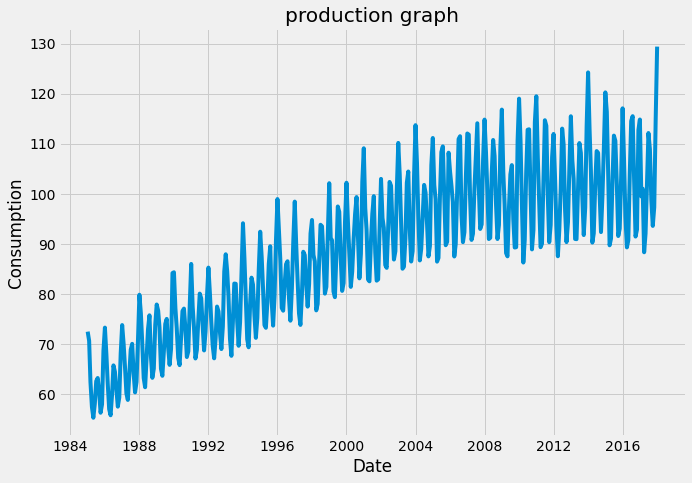

In [4]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

For time series forecasting, a series needs to be stationary (it should have a constant mean, variance, and covariance).<br>
But in this data, the mean is not constant as we can clearly see an upward trend.<br>
Level: The average value in the series.<br>
Trend: The increasing or decreasing value in the series.<br>
Seasonality: The repeating short-term cycle in the series.<br>
Noise: The random variation in the series.<br>
In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.<br>

So let us separate Trend and Seasonality from the time series.

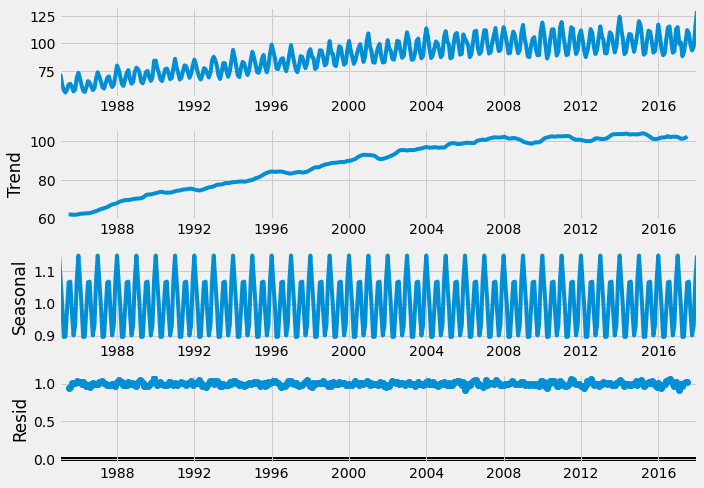

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

### 2. Stationarising the time series

<b>ADF (Augmented Dickey-Fuller) Test</b>

This test can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:<br>
<b>Null Hypothesis:</b> The series has a unit root (value of a =1)<br>
<b>Alternate Hypothesis:</b> The series has no unit root.<br>
If we fail to reject the null hypothesis, we can say that the series is non-stationary.<br>
If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.<br>

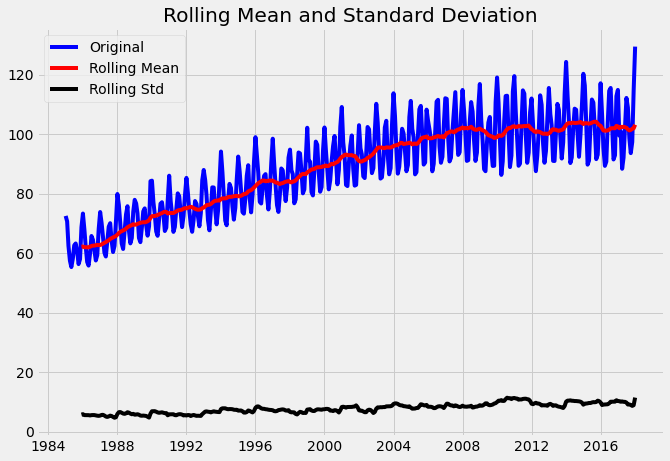

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis, so the data is non-stationary.

We take a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

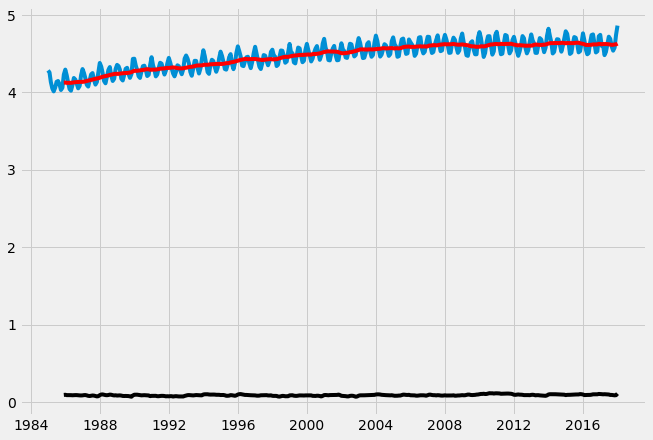

In [9]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.<br>
This way, we eliminate trends out of a series and obtain a more stationary series.

In [10]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

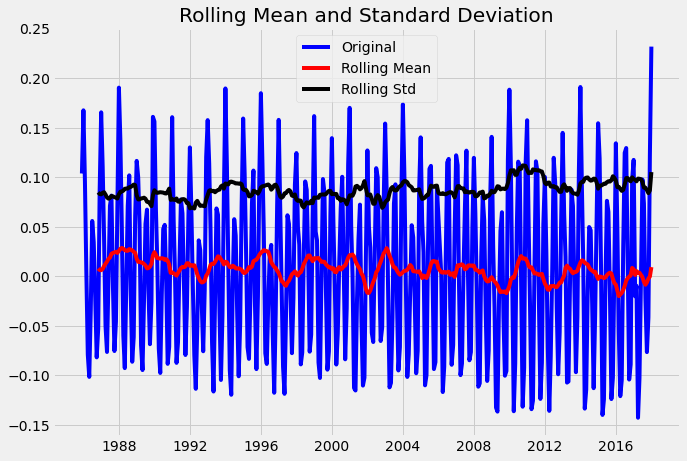

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [11]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

In [12]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.

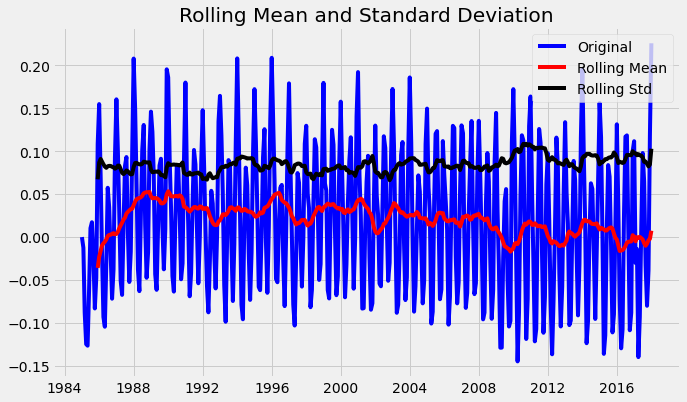

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [13]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

We need to also take care of the seasonality in the series. One such method for this task is differencing.<br>
Differencing is a method of transforming a time series dataset.It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality.<br>
Differencing is performed by subtracting the previous observation from the current observation.<br>
Perform the Dickey-Fuller test (ADFT) once again.

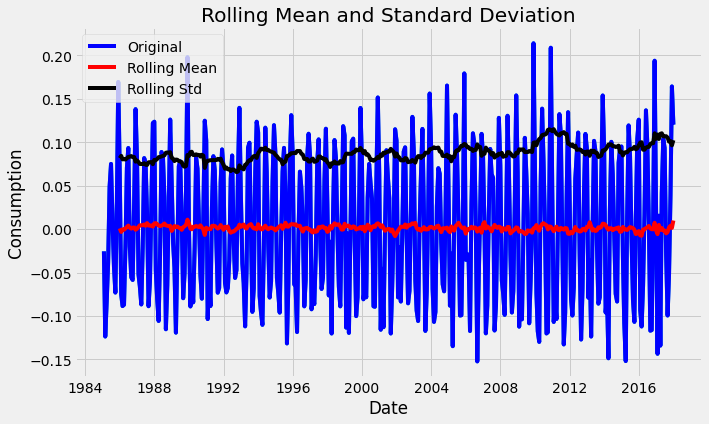

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [15]:
df_log_diff = df_log - df_log.shift() #differencing
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

The next step is to perform decomposition

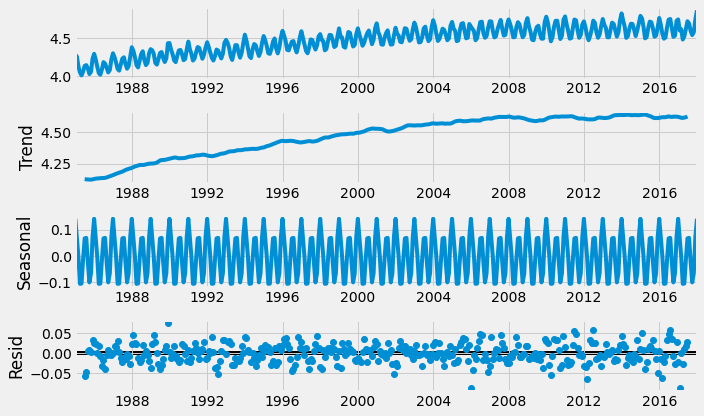

In [28]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation.

### 3. Finding the best parameters for our model

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms,

d → Number of nonseasonal differences needed for stationarity, and

q → Number of lagged forecast errors in the prediction equation.

Values of p and q come through ACF and PACF plots.

##### Autocorrelation Function(ACF)

Statistical correlation summarizes the strength of the relationship between two variables.<br>
Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively.

We can calculate the correlation for time series observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is an autocorrelation.

##### Partial Autocorrelation Function(PACF)

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The autocorrelation for observation and observation at a prior time step is comprised of both the direct correlation and indirect correlations. It is these indirect correlations that the partial autocorrelation function seeks to remove.

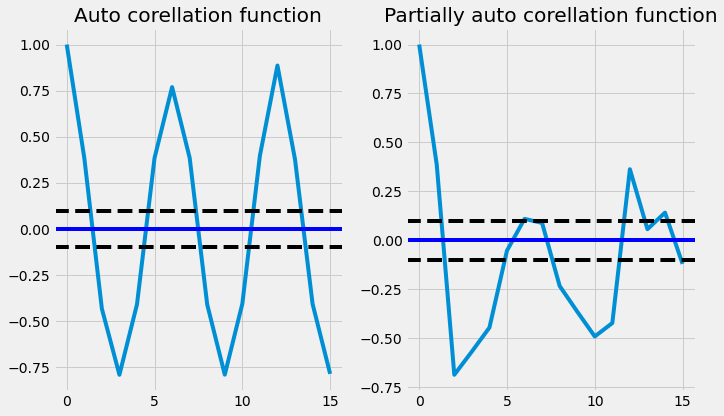

In [20]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

### 4. Fitting model

C:\Users\MrunmayiSA\.conda\envs\DS5230USML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\MrunmayiSA\.conda\envs\DS5230USML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\MrunmayiSA\.conda\envs\DS5230USML\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\MrunmayiSA\.conda\envs\DS5230USML\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RSS : 0.522632


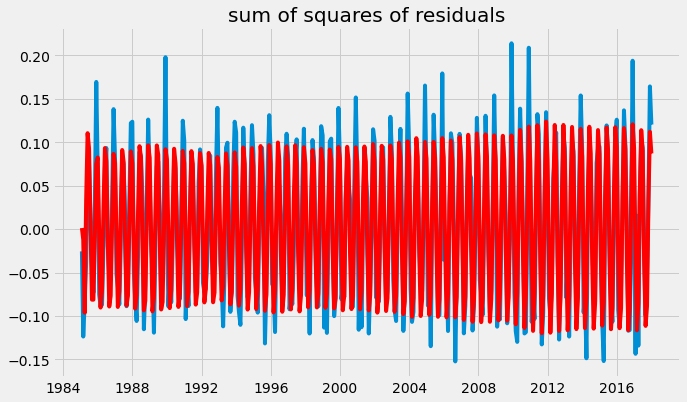

In [21]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

### 5. Prediction for 2017-2024

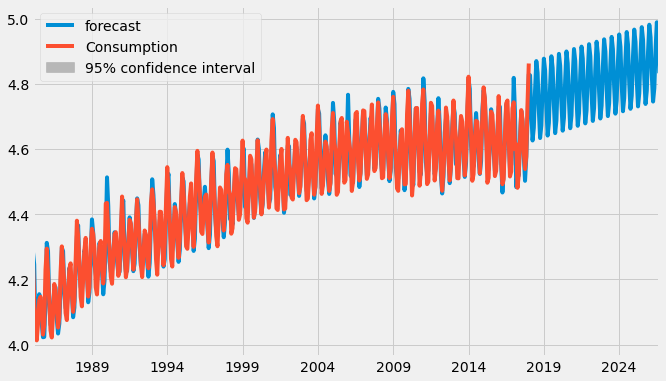

In [22]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)